In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration

In [2]:
df = pd.read_csv('spotify_churn_dataset.csv')
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


In [4]:
df.isnull().sum()

user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64

# Data Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

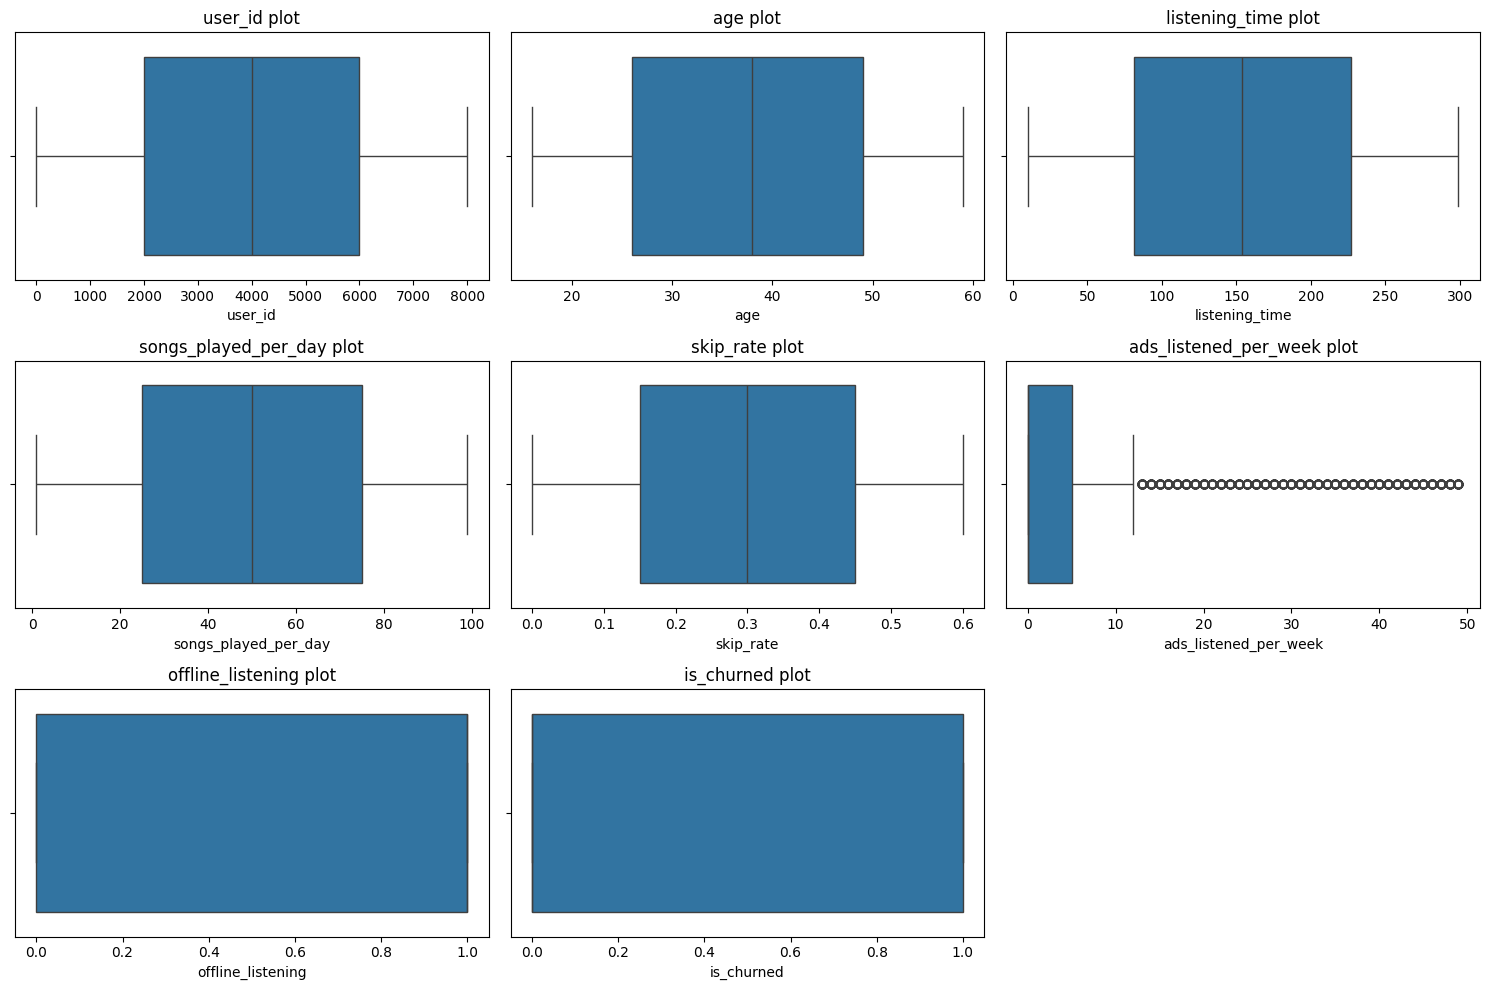

In [6]:
def boxplot(dataset):
    num_cols = df.select_dtypes(exclude = 'O').columns
    for i, j in enumerate(num_cols):
        plt.subplot(len(num_cols)//3+1, 3, i+1)
        sns.boxplot(data = dataset, x = j)
        plt.title(f"{j} plot")
    plt.tight_layout()

plt.figure(figsize = (15, 10))
boxplot(df)

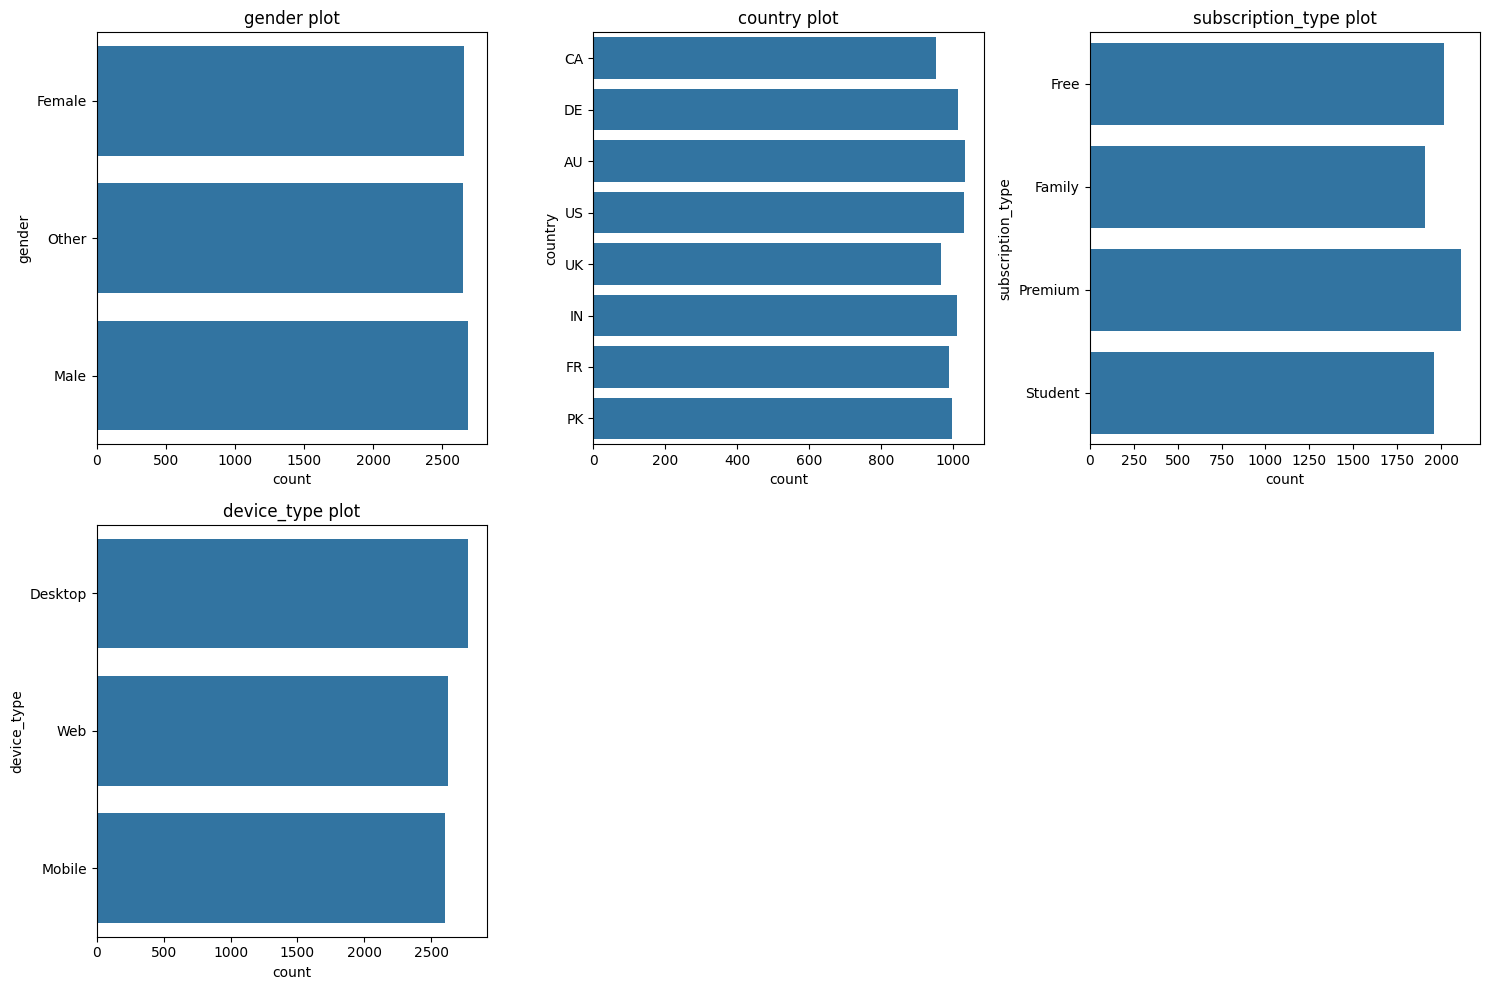

In [7]:
def countplot(dataset):
    cat_cols = df.select_dtypes(include = 'O').columns
    for i, j in enumerate(cat_cols):
        plt.subplot(len(cat_cols)//3+1, 3, i+1)
        sns.countplot(data = dataset, y = j)
        plt.title(f"{j} plot")
    plt.tight_layout()

plt.figure(figsize = (15, 10))
countplot(df)

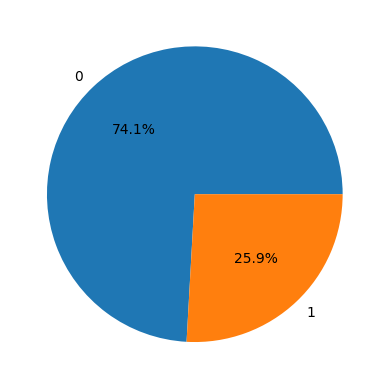

In [8]:
plt.pie(df.is_churned.value_counts(), labels = df.is_churned.value_counts().index, autopct = '%1.1f%%')
plt.show()

In [9]:
df = df.drop('user_id', axis = 1)

# Data Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop('is_churned', axis = 1)
y = df.is_churned

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42)

scaler = StandardScaler()
ohe = OneHotEncoder(drop = 'first')

preprocessing = ColumnTransformer([
    ("StandardScaler", scaler, X_train.select_dtypes(exclude = 'O').columns),
    ("OneHotEncoding", ohe, X_train.select_dtypes(include = 'O').columns)
])

X_train_scaled = preprocessing.fit_transform(X_train)
X_test_scaled = preprocessing.transform(X_test)

In [11]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, input_shape = (X_train_scaled.shape[1],), activation = 'elu'),
    Dense(64, activation = 'elu'),
    Dense(32, activation = 'elu'),
    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 20)

history = model.fit(X_train_scaled, y_train,
                    validation_data = (X_test_scaled, y_test),
                    callbacks = [early_stopping],
                   epochs = 100,
                   verbose = 1)




Epoch 1/100


188/188 [==============================] - 1s 1ms/step - loss: 0.5874 - accuracy: 0.7352 - val_loss: 0.5648 - val_accuracy: 0.7480
Epoch 2/100
188/188 [==============================] - 0s 853us/step - loss: 0.5790 - accuracy: 0.7388 - val_loss: 0.5664 - val_accuracy: 0.7480
Epoch 3/100
188/188 [==============================] - 0s 842us/step - loss: 0.5765 - accuracy: 0.7388 - val_loss: 0.5641 - val_accuracy: 0.7480
Epoch 4/100
188/188 [==============================] - 0s 848us/step - loss: 0.5753 - accuracy: 0.7388 - val_loss: 0.5653 - val_accuracy: 0.7480
Epoch 5/100
188/188 [==============================] - 0s 842us/step - loss: 0.5749 - accuracy: 0.7388 - val_loss: 0.5642 - val_accuracy: 0.7480
Epoch 6/100
188/188 [==============================] - 0s 842us/step - loss: 0.5738 - accuracy: 0.7388 - val_loss: 0.5672 - val_accuracy: 0.7480
Epoch 7/100
188/188 [==============================] - 0s 842us/step - loss: 0.5732 - accuracy: 0.7388 - val_loss: 0.5676 - val

# HyperParameter Tuning of ANN classifier

In [12]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score

def build_model(n_hidden1=128, n_hidden2=64, n_hidden3=32, activation='relu', learning_rate=0.001, optimizer='adam'):
    model = Sequential([
        Dense(n_hidden1, input_shape=(X_train_scaled.shape[1],), activation=activation),
        Dense(n_hidden2, activation=activation),
        Dense(n_hidden3, activation=activation),
        Dense(1, activation='sigmoid')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

classifier = KerasClassifier(model=build_model, verbose=0)

model__input_dim=X_train_scaled.shape[1]

param_grid = {
    "model__n_hidden1": [64, 128],
    "model__n_hidden2": [32, 64],
    "model__n_hidden3": [16],
    "model__activation": ["relu", "elu"],
    "model__learning_rate": [0.001],
    "model__optimizer": ["adam", "rmsprop"],
    "batch_size": [64],
    "epochs": [20, 30]
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid_cv = GridSearchCV(
    estimator=classifier,
    param_grid = param_grid,
    cv=cv,
    scoring='accuracy')

grid_cv.fit(X_train_scaled, y_train)


,estimator,KerasClassifi..._weight=None )
,param_grid,"{'batch_size': [64], 'epochs': [20, 30], 'model__activation': ['relu', 'elu'], 'model__learning_rate': [0.001], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...00279791052D0>


In [13]:
grid_cv.best_params_

{'batch_size': 64,
 'epochs': 20,
 'model__activation': 'elu',
 'model__learning_rate': 0.001,
 'model__n_hidden1': 64,
 'model__n_hidden2': 32,
 'model__n_hidden3': 16,
 'model__optimizer': 'rmsprop'}

In [14]:
y_pred = grid_cv.best_estimator_.model_.predict(X_test_scaled)
y_pred = pd.Series(y_pred.flatten())

y_pred = (y_pred >= 0.5).astype(int)

accuracy_score(y_test, y_pred)


63/63 [==============================] - 0s 437us/step


0.748

In [15]:
import pickle

# Saing the data preprocessing pipeline and model
with open('processing.pkl', 'wb') as file:
    pickle.dump(preprocessing, file)

best_model = grid_cv.best_estimator_.model_
best_model.save("model.h5") 


d:\Generative_AI_Course_Krish_Nayak_Course\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
